/usr/local/anaconda3/envs/mixedres2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1409053/2641197404.py:33: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img*255).astype(np.uint8)


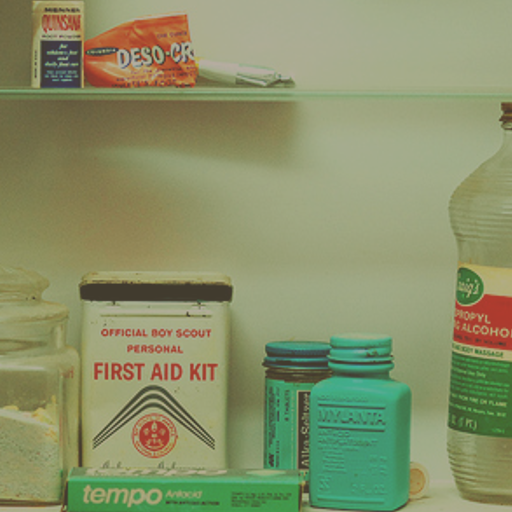

In [1]:
import sys
sys.path.append("../")

import os
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from timm.data import create_transform
import PIL.Image as Image
import numpy as np

from src.data.transforms import transforms_imagenet_eval

split = "val"
image_size = 512
data_dir = os.path.join("/edrive1/rchoudhu/ILSVRC2012", split)

val_transform = transforms_imagenet_eval(img_size=image_size)
data_val = datasets.ImageFolder(
    root=f"{data_dir}",
    transform=val_transform
)

unnorm = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

img, label = data_val[32432]
# Undo imagenet norm, then permute dims. 
img = unnorm(img).permute(1,2,0)
img = np.array(img*255).astype(np.uint8)
img = Image.fromarray(img)
img

In [6]:
import numpy as np
from PIL import ImageDraw

def create_hierarchical_patches(image_size, max_patch_size, min_patch_size, split_prob=0.3):
    """
    Create a hierarchical patch structure by recursively splitting patches.
    
    Args:
        image_size: Size of the square image (N for NxN)
        max_patch_size: Maximum patch size to start with
        min_patch_size: Minimum patch size to stop at
        split_prob: Probability of splitting a patch into smaller patches
    
    Returns:
        List of tuples (x, y, size) representing patch positions and sizes
    """
    def split_patch(x, y, size):
        patches = []
        if size <= min_patch_size or np.random.random() > split_prob:
            patches.append((x, y, size))
        else:
            new_size = size // 2
            # Recursively split into 4 smaller patches
            patches.extend(split_patch(x, y, new_size))
            patches.extend(split_patch(x + new_size, y, new_size))
            patches.extend(split_patch(x, y + new_size, new_size))
            patches.extend(split_patch(x + new_size, y + new_size, new_size))
        return patches
    
    # Start with initial grid of max_patch_size
    patches = []
    for y in range(0, image_size, max_patch_size):
        for x in range(0, image_size, max_patch_size):
            patches.extend(split_patch(x, y, max_patch_size))
    print("Total patches:", len(patches))
    return patches

def draw_hierarchical_grid(image, patches):
    """
    Draw a hierarchical grid on a copy of the input image.
    
    Args:
        image: PIL Image
        patches: List of (x, y, size) tuples representing patches
    
    Returns:
        PIL Image with hierarchical grid overlay
    """
    # Make a copy of the image to avoid modifying the original
    img_with_grid = image.copy()
    draw = ImageDraw.Draw(img_with_grid)
    
    # Draw rectangles for each patch
    for x, y, size in patches:
        draw.rectangle([(x, y), (x + size, y + size)], 
                      outline='white', width=1)
    
    return img_with_grid

Total patches: 462


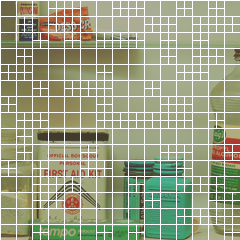

In [7]:
# Example usage
patches = create_hierarchical_patches(image_size=image_size,  # Your image size
                                    max_patch_size=16, 
                                    min_patch_size=8,
                                    split_prob=0.4)
grid_img = draw_hierarchical_grid(img, patches)
grid_img